<a href="https://colab.research.google.com/github/Chunkalex/BetterBack/blob/main/medsam_rep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==========================================
# 1. ENVIRONMENT SETUP & INSTALLATION
# ==========================================
import sys
import os
import glob
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from skimage import transform, io
import torch.nn.functional as F

# Install MedSAM and dependencies
!pip install -q git+https://github.com/bowang-lab/MedSAM.git
!pip install -q matplotlib numpy opencv-python

# Download Model Checkpoint
!wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

# Clone Dataset
if not os.path.exists("OCT-AND-EYE-FUNDUS-DATASET"):
    print("Downloading Dataset...")
    !git clone https://github.com/Traslational-Visual-Health-Laboratory/OCT-AND-EYE-FUNDUS-DATASET.git

# Import SAM registry after installation
from segment_anything import sam_model_registry

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.8/515.8 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 146.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 94.1 MB/s eta 0:00:00
--2025-12-02 08:24:02--  https://zenodo.org/records/10689643/files/medsam_vit_b.pth
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 188.185.43.153, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375049145 (358M) [application/octet-stream]
Saving to: ‘medsam_vit_b.pth’

medsam_vit_b.pth    100%[===================>] 357.67M  2.33MB/s    in 3m 28s  

2025-12-02 08:27:31 (1.72 MB/s) 

In [2]:
# ==========================================
# 2. MODEL LOADING
# ==========================================
MedSAM_CKPT_PATH = "medsam_vit_b.pth"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(DEVICE)
medsam_model.eval()

Using device: cuda:0


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [3]:
# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)

    # Shape fix: Ensure box shape is (1, 1, 4)
    if len(box_torch.shape) == 1:
        box_torch = box_torch.unsqueeze(0).unsqueeze(0)
    elif len(box_torch.shape) == 2:
        box_torch = box_torch.unsqueeze(1)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)
    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )
    low_res_pred = low_res_pred.squeeze().cpu().numpy()
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [52]:
# ==========================================
# 4. USER CONFIGURATION (MANUAL INPUT)
# ==========================================

# Define the data path
DATA_PATH = "OCT-AND-EYE-FUNDUS-DATASET/EYE FUNDUS/EYE FUNDUS1"
image_number = 16 # From 0-99 (n+1, 100 images
# Get the first image only
image_files = sorted(glob.glob(os.path.join(DATA_PATH, "*")))
if not image_files:
    print("No images found! Check dataset path.")
else:
    img_path = image_files[image_number] # Select the first image
    print(f"Processing image: {img_path}")
    print(f"image number: {image_number}")

    # === MANUAL BOX COORDINATES ===
    # Format: [x_min, y_min, x_max, y_max]
    # You must change these numbers to match the object you want to segment in the first image.
    # For example, if there is a lesion in the top left, adjust accordingly.
    # These are placeholder values:
    manual_box = np.array([200, 300, 600, 700])
    print(f"Using manual bounding box: {manual_box}")

Processing image: OCT-AND-EYE-FUNDUS-DATASET/EYE FUNDUS/EYE FUNDUS1/0017_OD_f_1.jpg
image number: 16
Using manual bounding box: [200 300 600 700]


In [53]:
    # ==========================================
    # 5. RUNNING INFERENCE
    # ==========================================

    # A. Load Image
    img_np = io.imread(img_path)
    if len(img_np.shape) == 2:
        img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
    else:
        img_3c = img_np

    H, W, _ = img_3c.shape

    # B. Preprocessing
    img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)
    img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(DEVICE)

    # C. Prepare the Prompt (Scaling manual coordinates to 1024x1024)
    box_1024 = manual_box / np.array([W, H, W, H]) * 1024

    # D. Inference
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)
        segmentation = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

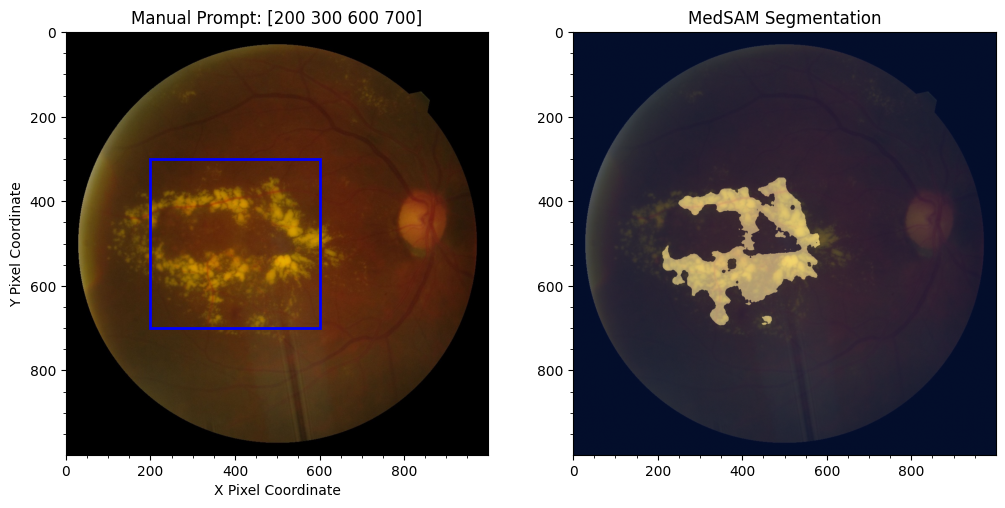

In [54]:
# ==========================================
# 6. VISUALIZATION (With Coordinates)
# ==========================================
fig, ax = plt.subplots(1, 2, figsize=(12, 6)) # Made figure slightly larger

# Left: Image with your Manual Box
ax[0].imshow(img_3c)
x0, y0, x1, y1 = manual_box
ax[0].add_patch(plt.Rectangle((x0, y0), x1-x0, y1-y0, edgecolor='blue', facecolor='none', lw=2))
ax[0].set_title(f"Manual Prompt: {manual_box}")

# --- ENABLE COORDINATES ---
# ax[0].axis('off')  <-- I commented this out so coordinates show up
# ax[0].grid(True, which='both', color='white', linestyle='--', alpha=0.5) # Adds a helper grid
ax[1].grid(False) # False to disable
ax[0].minorticks_on() # Adds small tick marks for better precision
ax[0].set_xlabel("X Pixel Coordinate")
ax[0].set_ylabel("Y Pixel Coordinate")

# Right: Segmentation Result
ax[1].imshow(img_3c)
ax[1].imshow(segmentation, alpha=0.5, cmap='YlGnBu_r')
ax[1].set_title("MedSAM Segmentation")

# --- ENABLE COORDINATES ---
# ax[1].axis('off') <-- # Commented out to show numbers
# ax[1].grid(True, which='both', color='white', linestyle='--', alpha=0.5) # False to disable
ax[1].grid(False) # False to disable
ax[1].minorticks_on() # Adds small tick marks for better precision

plt.show()